In [1]:
import numpy as np
from nozzle import Params, Nozzle, Spectral
import matplotlib.pyplot as plt

Text(0, 0.5, '$B$')

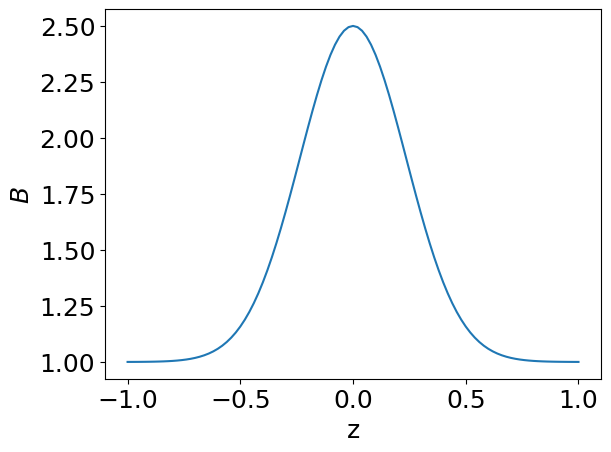

In [2]:
# magnetic field
spectral = Spectral(101, "symmetric", "FD")
params = Params(Mm=0.5, constant_v=False)
B0 = params.B0
R = params.R
Bm = params.Bm
Delta = params.Delta 

x = spectral.x
B = B0*(1+R*np.exp(-(x/Delta)**2))
plt.plot(x,B)
plt.xlabel("z")
plt.ylabel("$B$")

Text(0.5, 1.0, 'velocity profile')

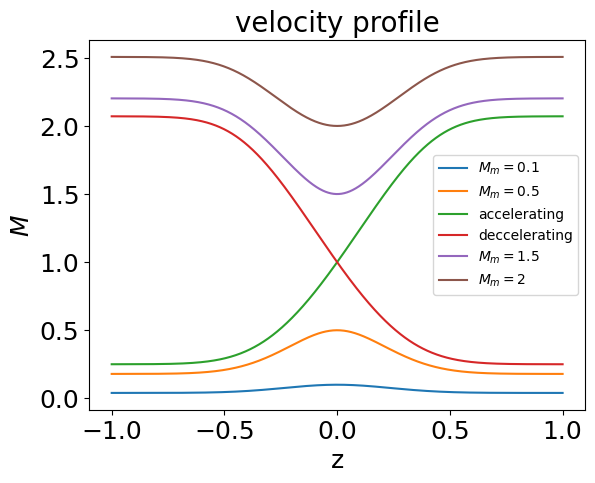

In [3]:
params_list = [
    Params(Mm=0.1, constant_v=False),
    Params(Mm=0.5, constant_v=False),
    Params(Mm=1, accelerating=True),
    Params(Mm=1, accelerating=False),
    Params(Mm=1.5, constant_v=False),
    Params(Mm=2, constant_v=False)
]
x = np.linspace(-1,1,1001)
for params in params_list:
    nozzle = Nozzle(params, x)
    if params.accelerating == True:
        label = "accelerating"
    elif params.accelerating == False:
        label = "deccelerating"
    else: # paras.accelerating is None
        label = f"$M_m={params.Mm}$"
    plt.plot(x, nozzle.v0, label=label)
plt.legend(fontsize="medium")
plt.xlabel("z")
plt.ylabel("$M$")
plt.title("velocity profile")

# constant velocity

ValueError: x and y must have same first dimension, but have shapes (101,) and (201,)

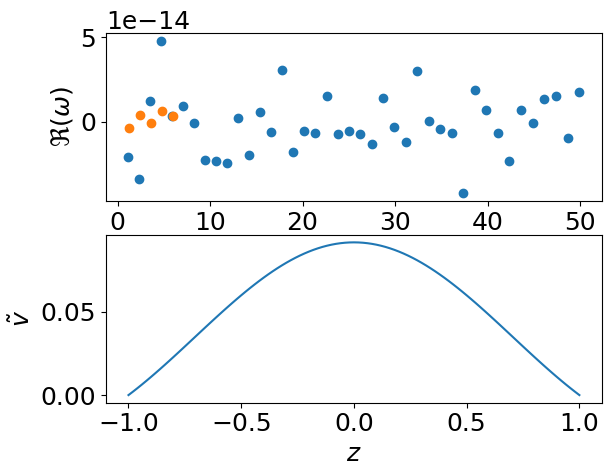

In [8]:
v0 = 0.5
methods = ["fd", "fe-bspline", "fe-sine"]

x = np.linspace(-1,1,101)
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
for method in methods:
    data = np.load(f"data/constant-v/{method}-v0={v0}.npz")
    omega = data["omega"]
    V = data["v"]
    ax1.plot(omega.real, omega.imag, "o")
    ax1.set_xlabel("$\\Re(\omega)$")
    ax1.set_ylabel("$\\Re(\omega)$")

    ax2.plot(x, V[:,0].real)
    ax2.set_xlabel("$z$")
    ax2.set_ylabel("$\\tilde{v}$")

ax1.legend(methods)

# subsonic case

#  supersonic case

# transonic case